# Main classification model

Model classifies 
* 0: Glasses/Sunglasses', 
* 1: 'Trousers/Jeans', 
* 3: 'Shoes

# Import libraries

In [1]:
import io
import itertools
import numpy as np
import sklearn.metrics
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
import matplotlib.pyplot as plt

# Load the data

Data train files: ['images', 'labels']
Size of the images: (12963, 120, 90, 3)
Size of the labels: (12963,)
The label of 896'th image is 1


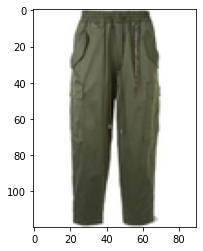

In [2]:
data_train = np.load(r"data/Primary categories - Train.npz")
data_validation = np.load(r"data/Primary categories - Validation.npz")
data_test = np.load(r"data/Primary categories - Test.npz")

print("Data train files: {}".format(data_train.files))
print("Size of the images: {}".format(data_train['images'].shape))
print("Size of the labels: {}".format(data_train['labels'].shape))

n = np.random.randint(0, 4002)
plt.imshow(data_train['images'][n])
print("The label of {}'th image is {}".format(n, data_train['labels'][n]))

In [3]:
images_train = data_train['images']
labels_train = data_train['labels']

images_val = data_validation['images']
labels_val = data_validation['labels']

images_test = data_test['images']
labels_test = data_test['labels']


In [4]:
images_train = images_train/255.0
images_val = images_val/255.0
images_test = images_test/255.0 

# Training the model

In [5]:
EPOCHS = 15
BATCH_SIZE = 64 #power of 2

HP_FILTER_SIZE = hp.HParam("filter_size", hp.Discrete([3,5,7]))
HP_FILTER_NUM = hp.HParam("filter_number", hp.Discrete([32, 64, 96, 128]))

METRIC_ACCURACY = "accuracy"

with tf.summary.create_file_writer(r'Logs/Model 1/hparams_tuning/').as_default():
    hp.hparams_config(
        hparams=[HP_FILTER_SIZE, HP_FILTER_NUM],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name="Accuracy")])

In [6]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
        cm (array, shape = [n, n]): a confusion matrix of integer classes
        class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [7]:
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image
    

In [11]:
def train_test_model(hparams, session_num):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(hparams[HP_FILTER_NUM],
                              hparams[HP_FILTER_SIZE],
                              activation = "relu",
                              input_shape = (120,90,3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(hparams[HP_FILTER_NUM], 3, activation= "relu"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3)
    ])
    
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer="adam", loss=loss_fn, metrics=['accuracy'])
    

    log_dir = "Logs\\Model 1\\fit\\" + "run {}".format(session_num)
    
  
    file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')
    
    def log_confusion_matrix(epoch, logs):
        
        test_pred_raw = model.predict(images_val)
        test_pred = np.argmax(test_pred_raw, axis=1)

        
        cm = sklearn.metrics.confusion_matrix(labels_val, test_pred)
       
        figure = plot_confusion_matrix(cm, class_names=['Glasses/Sunglasses', 'Trousers/Jeans', 'Shoes'])
        cm_image = plot_to_image(figure)

        
        with file_writer_cm.as_default():
            tf.summary.image("Confusion Matrix", cm_image, step=epoch)
    
    
    
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)
    cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
    

    
 
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        mode = 'auto',
        min_delta = 0,
        patience = 2,
        verbose = 0, 
        restore_best_weights = True
    )
    

    model.fit(
        images_train,
        labels_train,
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        callbacks = [tensorboard_callback, cm_callback, early_stopping],
        validation_data = (images_val,labels_val),
        verbose = 2
    )
    
    

    _, accuracy = model.evaluate(images_val,labels_val)
    

    model.save(r"saved_models\Model 1\Run-{}".format(session_num))
    
    return accuracy

In [12]:
def run(log_dir, hparams, session_num):
    with tf.summary.create_file_writer(log_dir).as_default():
        hp.hparams(hparams)
        accuracy = train_test_model(hparams, session_num)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step = 1)

In [13]:
session_num = 1

for filter_size in HP_FILTER_SIZE.domain.values:
    for filter_num in HP_FILTER_NUM.domain.values:

        hparams = {
            HP_FILTER_SIZE: filter_size,
            HP_FILTER_NUM: filter_num
        }

        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('Logs/Model 1/hparam_tuning/' + run_name, hparams, session_num)

        session_num += 1

--- Starting trial: run-1
{'filter_size': 3, 'filter_number': 32}
Epoch 1/15
203/203 - 31s - loss: 0.1194 - accuracy: 0.9711 - val_loss: 0.0058 - val_accuracy: 0.9994
Epoch 2/15
203/203 - 31s - loss: 0.0106 - accuracy: 0.9988 - val_loss: 0.0051 - val_accuracy: 0.9994
Epoch 3/15
203/203 - 31s - loss: 0.0219 - accuracy: 0.9948 - val_loss: 0.0873 - val_accuracy: 0.9660
Epoch 4/15
203/203 - 30s - loss: 0.0074 - accuracy: 0.9991 - val_loss: 0.0049 - val_accuracy: 0.9994
Epoch 5/15
203/203 - 29s - loss: 0.0060 - accuracy: 0.9988 - val_loss: 0.0103 - val_accuracy: 0.9988
Epoch 6/15
203/203 - 30s - loss: 0.0066 - accuracy: 0.9985 - val_loss: 0.0052 - val_accuracy: 0.9994
51/51 [==============================] - 1s 18ms/step - loss: 0.0049 - accuracy: 0.9994
INFO:tensorflow:Assets written to: saved_models\Model 1\Run-1\assets
--- Starting trial: run-2
{'filter_size': 3, 'filter_number': 64}
Epoch 1/15
203/203 - 64s - loss: 0.2006 - accuracy: 0.9709 - val_loss: 0.0132 - val_accuracy: 0.9981
Epoc

Epoch 5/15
203/203 - 161s - loss: 0.0216 - accuracy: 0.9952 - val_loss: 0.0144 - val_accuracy: 0.9957
Epoch 6/15
203/203 - 163s - loss: 0.0411 - accuracy: 0.9920 - val_loss: 0.1450 - val_accuracy: 0.9451
51/51 [==============================] - 4s 87ms/step - loss: 0.0078 - accuracy: 0.9988
INFO:tensorflow:Assets written to: saved_models\Model 1\Run-12\assets


In [5]:
%load_ext tensorboard
%tensorboard --logdir "Logs/Model 1/hparam_tuning"


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
  %reload_ext tensorboard